#### Copyright 2017 Google LLC.

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

 # Croisements de caractéristiques

 **Objectifs d'apprentissage :**
  * Améliorer un modèle de régression linéaire en ajoutant des caractéristiques synthétiques (suite de l'exercice précédent)
  * Utiliser la fonction d'entrée pour convertir des objets Pandas `DataFrame` en `Tensors`, et invoquer la fonction d'entrée dans les opérations `fit()` et `predict()`
  * Utiliser l'algorithme d'optimisation FTRL pour l'apprentissage de modèle
  * Créer des caractéristiques synthétiques au moyen de l'encodage one-hot, du binning et des croisements de caractéristiques

 ## Configuration

 Comme pour les exercices précédents, vous allez commencer par définir l'entrée et par créer le code de chargement de données.

In [0]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=",")

california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))

In [0]:
def preprocess_features(california_housing_dataframe):
  """Prepares input features from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  selected_features = california_housing_dataframe[
    ["latitude",
     "longitude",
     "housing_median_age",
     "total_rooms",
     "total_bedrooms",
     "population",
     "households",
     "median_income"]]
  processed_features = selected_features.copy()
  # Create a synthetic feature.
  processed_features["rooms_per_person"] = (
    california_housing_dataframe["total_rooms"] /
    california_housing_dataframe["population"])
  return processed_features

def preprocess_targets(california_housing_dataframe):
  """Prepares target features (i.e., labels) from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  # Scale the target to be in units of thousands of dollars.
  output_targets["median_house_value"] = (
    california_housing_dataframe["median_house_value"] / 1000.0)
  return output_targets

In [4]:
# Choose the first 12000 (out of 17000) examples for training.
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_targets = preprocess_targets(california_housing_dataframe.head(12000))

# Choose the last 5000 (out of 17000) examples for validation.
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))

# Double-check that we've done the right thing.
print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.6,2645.3,538.2,1431.1,500.3,3.9,2.0
std,2.1,2.0,12.6,2194.7,422.8,1170.2,385.2,1.9,1.2
min,32.5,-124.3,1.0,8.0,1.0,3.0,1.0,0.5,0.0
25%,33.9,-121.8,18.0,1469.0,297.0,790.0,282.0,2.6,1.5
50%,34.2,-118.5,29.0,2131.0,434.0,1165.5,409.0,3.5,1.9
75%,37.7,-118.0,37.0,3141.0,646.0,1719.0,602.0,4.8,2.3
max,42.0,-114.3,52.0,32627.0,6445.0,35682.0,6082.0,15.0,55.2


Validation examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.6,-119.6,28.6,2639.7,542.2,1426.0,503.5,3.9,2.0
std,2.1,2.0,12.6,2144.3,418.3,1092.4,383.0,1.9,1.1
min,32.5,-124.3,1.0,2.0,2.0,6.0,2.0,0.5,0.1
25%,33.9,-121.8,18.0,1440.0,296.0,788.8,280.0,2.6,1.5
50%,34.2,-118.5,29.0,2115.0,434.5,1170.5,409.0,3.5,1.9
75%,37.7,-118.0,37.0,3166.0,657.0,1727.8,611.0,4.8,2.3
max,41.9,-114.5,52.0,37937.0,5471.0,16122.0,5189.0,15.0,41.3


Training targets summary:


,median_house_value
count,12000.0
mean,206.7
std,116.4
min,15.0
25%,118.5
50%,179.8
75%,264.5
max,500.0


Validation targets summary:


,median_house_value
count,5000.0
mean,208.7
std,115.0
min,15.0
25%,122.7
50%,181.3
75%,266.5
max,500.0


In [0]:
def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

In [0]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

 ## Algorithme d'optimisation FTRL

Les modèles linéaires de grande dimension tirent parti de l'utilisation d'une variante de l'optimisation basée sur le gradient, appelée FTRL. L'avantage de cet algorithme est de permettre une mise à l'échelle du taux d'apprentissage qui diffère en fonction du coefficient, ce qui peut se révéler particulièrement utile si certaines caractéristiques utilisent rarement des valeurs non nulles (il est aussi parfaitement adapté à la régularisation L1). L'algorithme FTRL peut être appliqué à l'aide de la classe [FtrlOptimizer](https://www.tensorflow.org/api_docs/python/tf/train/FtrlOptimizer).

In [0]:
def train_model(
    learning_rate,
    steps,
    batch_size,
    feature_columns,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a linear regression model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    feature_columns: A `set` specifying the input feature columns to use.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `LinearRegressor` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps / periods

  # Create a linear regressor object.
  my_optimizer = tf.train.FtrlOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=feature_columns,
      optimizer=my_optimizer
  )
  
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["median_house_value"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["median_house_value"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["median_house_value"], 
                                                    num_epochs=1, 
                                                    shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")

  
  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  return linear_regressor

Training model...
RMSE (on training data):
  period 00 : 200.38
  period 01 : 116.14
  period 02 : 113.14
  period 03 : 218.41
  period 04 : 173.28
  period 05 : 145.92
  period 06 : 126.48
  period 07 : 136.18
  period 08 : 146.66
  period 09 : 139.23
Model training finished.


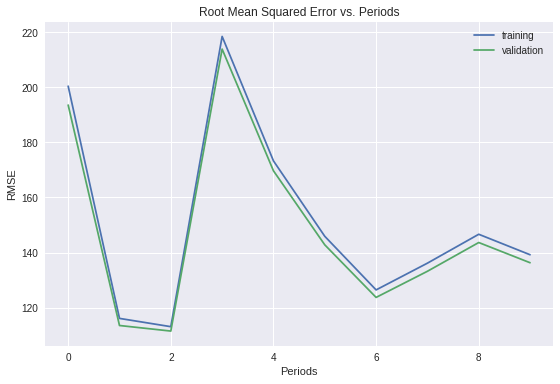

In [8]:
_ = train_model(
    learning_rate=1.0,
    steps=500,
    batch_size=100,
    feature_columns=construct_feature_columns(training_examples),
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

 ## Encodage one-hot pour les caractéristiques discrètes

Les caractéristiques discrètes (chaînes, énumérations et entiers) sont généralement converties en familles de caractéristiques binaires avant d'apprendre un modèle de régression logistique.

Supposons que vous ayez créé une caractéristique synthétique pouvant utiliser la valeur `0`, `1` ou `2`, et qu'il existe quelques points d'apprentissage :

| # | feature_value |
|---|---------------|
| 0 |             2 |
| 1 |             0 |
| 2 |             1 |

Pour chaque valeur catégorique possible, vous créez une caractéristique **binaire** de **valeurs réelles** pouvant utiliser une seule des deux valeurs possibles : 1.0 si l'exemple contient cette valeur et 0.0 dans le cas contraire. Dans l'exemple ci-dessus, la caractéristique catégorique est convertie en trois caractéristiques, et les points d'apprentissage se présentent désormais comme suit :

| # | feature_value_0 | feature_value_1 | feature_value_2 |
|---|-----------------|-----------------|-----------------|
| 0 |             0.0 |             0.0 |             1.0 |
| 1 |             1.0 |             0.0 |             0.0 |
| 2 |             0.0 |             1.0 |             0.0 |

 ## Caractéristiques binaires

La caractéristique `population` peut être répartie dans les trois catégories suivantes (par exemple) :
- `catégorie_0` (`< 5000`) : correspondant aux îlots urbains les moins peuplés
- `catégorie_1` (`5000 - 25000`) : correspondant aux îlots urbains moyennement peuplés
- `catégorie_2` (`> 25000`) :  correspondant aux îlots urbains densément peuplés

Compte tenu des définitions de catégories ci-dessus, le vecteur `population` suivant :

    [[10001], [42004], [2500], [18000]]

devient le vecteur de caractéristiques binaire :

    [[1], [2], [0], [1]]

Les valeurs de caractéristique sont désormais les index de catégorie. Notez que ces index sont considérés comme des caractéristiques discrètes. En règle générale, ces dernières sont encore converties en représentations one-hot, mais cette opération est effectuée de manière transparente.

Pour définir des colonnes de caractéristiques pour des caractéristiques binaires, vous pouvez utiliser [`bucketized_column`] (https://www.tensorflow.org/api_docs/python/tf/feature_column/bucketized_column) au lieu de `numeric_column`. Cette fonction prend une colonne numérique comme entrée et la transforme en une caractéristique binaire à l'aide des limites de catégorie indiquées dans l'argument `boundaries`. Le code suivant définit des colonnes de caractéristiques binaires pour `households` et `longitude` ; la fonction `get_quantile_based_boundaries` calcule les limites sur la base de quantiles, de sorte que chaque catégorie contienne un nombre égal d'éléments.

In [0]:
def get_quantile_based_boundaries(feature_values, num_buckets):
  
  """Calcule les limites sur la base de quantiles, de sorte que chaque catégorie 
  contienne un nombre égal d'éléments."""
  
  boundaries = np.arange(1.0, num_buckets) / num_buckets
  quantiles = feature_values.quantile(boundaries)
  return [quantiles[q] for q in quantiles.keys()]

# Divide households into 7 buckets.
households = tf.feature_column.numeric_column("households")
bucketized_households = tf.feature_column.bucketized_column(
  households, boundaries=get_quantile_based_boundaries(
    california_housing_dataframe["households"], 7))

# Divide longitude into 10 buckets.
longitude = tf.feature_column.numeric_column("longitude")
bucketized_longitude = tf.feature_column.bucketized_column(
  longitude, boundaries=get_quantile_based_boundaries(
    california_housing_dataframe["longitude"], 10))

 ## Tâche 1 : Apprendre le modèle sur des colonnes de caractéristiques binaires
**Effectuez un binning sur toutes les caractéristiques valorisées réelles de l'exemple, entraînez le modèle et constatez si cela permet d'améliorer les résultats.**

Dans le bloc de code qui précède, deux colonnes valorisées réelles (en l'occurrence `households` et `longitude`) ont été transformées en colonnes de caractéristiques binaires. Votre tâche consiste à effectuer un binning sur les autres colonnes, puis d'exécuter le code pour entraîner le modèle. Plusieurs méthodes heuristiques peuvent être utilisées pour trouver l'intervalle des catégories. Dans cet exercice, vous allez utiliser une technique basée sur des quantiles. Cette dernière choisit les limites de catégorie, de telle sorte que chaque catégorie possède le même nombre d'exemples.

In [0]:
def construct_feature_columns():
  """Construct the TensorFlow Feature Columns.

  Returns:
    A set of feature columns
  """ 
  households = tf.feature_column.numeric_column("households")
  longitude = tf.feature_column.numeric_column("longitude")
  latitude = tf.feature_column.numeric_column("latitude")
  housing_median_age = tf.feature_column.numeric_column("housing_median_age")
  median_income = tf.feature_column.numeric_column("median_income")
  rooms_per_person = tf.feature_column.numeric_column("rooms_per_person")
  
  # Divide households into 7 buckets.
  bucketized_households = tf.feature_column.bucketized_column(
    households, boundaries=get_quantile_based_boundaries(
      training_examples["households"], 7))

  # Divide longitude into 10 buckets.
  bucketized_longitude = tf.feature_column.bucketized_column(
    longitude, boundaries=get_quantile_based_boundaries(
      training_examples["longitude"], 10))

  #
  # YOUR CODE HERE: bucketize the following columns, following the example above:
  #
  bucketized_latitude = tf.feature_column.bucketized_column(
    latitude, boundaries=get_quantile_based_boundaries(
      training_examples["latitude"], 10))
  bucketized_housing_median_age = tf.feature_column.bucketized_column(
    housing_median_age, boundaries=get_quantile_based_boundaries(
      training_examples["housing_median_age"], 7))
  bucketized_median_income = tf.feature_column.bucketized_column(
      median_income,boundaries=get_quantile_based_boundaries(
      training_examples["median_income"], 7))
  bucketized_rooms_per_person = tf.feature_column.bucketized_column(
      rooms_per_person,boundaries=get_quantile_based_boundaries(
      training_examples["rooms_per_person"], 7))
  
  feature_columns = set([
    bucketized_longitude,
    bucketized_latitude,
    bucketized_housing_median_age,
    bucketized_households,
    bucketized_median_income,
    bucketized_rooms_per_person])
  
  return feature_columns


Training model...
RMSE (on training data):
  period 00 : 169.40
  period 01 : 143.27
  period 02 : 126.90
  period 03 : 115.81
  period 04 : 107.88
  period 05 : 102.03
  period 06 : 97.51
  period 07 : 93.92
  period 08 : 90.93
  period 09 : 88.48
Model training finished.


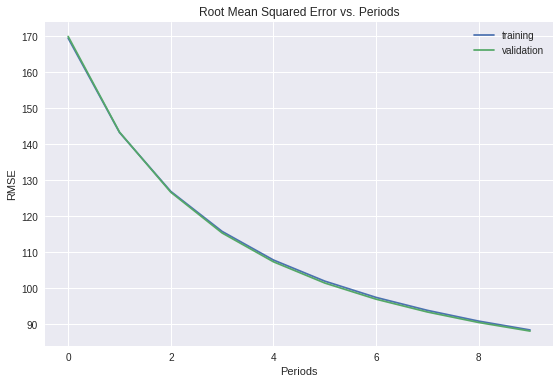

In [11]:
_ = train_model(
    learning_rate=1.0,
    steps=500,
    batch_size=100,
    feature_columns=construct_feature_columns(),
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

 ### Solution

Cliquez ci-dessous pour afficher une solution.

 Vous vous demandez peut-être comment déterminer le nombre de catégories à utiliser. Cela dépend, bien évidemment, des données. Dans le cas présent, nous avons simplement sélectionné des valeurs arbitraires afin d'obtenir un modèle de taille raisonnable.

In [0]:
def construct_feature_columns():
  """Construct the TensorFlow Feature Columns.

  Returns:
    A set of feature columns
  """ 
  households = tf.feature_column.numeric_column("households")
  longitude = tf.feature_column.numeric_column("longitude")
  latitude = tf.feature_column.numeric_column("latitude")
  housing_median_age = tf.feature_column.numeric_column("housing_median_age")
  median_income = tf.feature_column.numeric_column("median_income")
  rooms_per_person = tf.feature_column.numeric_column("rooms_per_person")
  
  # Divide households into 7 buckets.
  bucketized_households = tf.feature_column.bucketized_column(
    households, boundaries=get_quantile_based_boundaries(
      training_examples["households"], 7))

  # Divide longitude into 10 buckets.
  bucketized_longitude = tf.feature_column.bucketized_column(
    longitude, boundaries=get_quantile_based_boundaries(
      training_examples["longitude"], 10))
  
  # Divide latitude into 10 buckets.
  bucketized_latitude = tf.feature_column.bucketized_column(
    latitude, boundaries=get_quantile_based_boundaries(
      training_examples["latitude"], 10))

  # Divide housing_median_age into 7 buckets.
  bucketized_housing_median_age = tf.feature_column.bucketized_column(
    housing_median_age, boundaries=get_quantile_based_boundaries(
      training_examples["housing_median_age"], 7))
  
  # Divide median_income into 7 buckets.
  bucketized_median_income = tf.feature_column.bucketized_column(
    median_income, boundaries=get_quantile_based_boundaries(
      training_examples["median_income"], 7))
  
  # Divide rooms_per_person into 7 buckets.
  bucketized_rooms_per_person = tf.feature_column.bucketized_column(
    rooms_per_person, boundaries=get_quantile_based_boundaries(
      training_examples["rooms_per_person"], 7))
  
  feature_columns = set([
    bucketized_longitude,
    bucketized_latitude,
    bucketized_housing_median_age,
    bucketized_households,
    bucketized_median_income,
    bucketized_rooms_per_person])
  
  return feature_columns

In [0]:
_ = train_model(
    learning_rate=1.0,
    steps=500,
    batch_size=100,
    feature_columns=construct_feature_columns(),
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

 ## Croisement de caractéristiques

Le croisement de plusieurs caractéristiques est une méthode astucieuse pour l'apprentissage des relations non linéaires à l'aide d'un modèle linéaire. Dans le cas présent, si l'on se contente d'utiliser la caractéristique `latitude` pour l'apprentissage, il se peut que le modèle apprenne que les îlots urbains situés à une latitude donnée (ou dans une plage de latitudes spécifique, étant donné qu'un binning a été effectué) sont davantage susceptibles d'être plus chers que d'autres. Il en va de même pour la caractéristique `longitude`. Cependant si l'on croise la caractéristique `longitude` avec `latitude`, la caractéristique croisée représente un îlot urbain bien défini. Si le modèle apprend que certains îlots (situés dans une plage de latitudes et de longitudes) sont plus susceptibles d'être plus chers que d'autres, cela constitue un signal plus fort que deux caractéristiques prises en compte séparément.

Pour le moment, seules les caractéristiques discrètes peuvent faire l'objet de croisements dans l'API des colonnes de caractéristiques. Pour croiser deux valeurs continues, comme `latitude` ou `longitude`, un binning peut être effectué.

Si vous croisez les caractéristiques `latitude` et `longitude` (supposons, par exemple, que la caractéristique `longitude` ait été placée dans `2` catégories et que `latitude` possède `3` catégories), vous obtiendrez six caractéristiques binaires croisées. Chacune d'elles recevra alors sa propre pondération lors de l'apprentissage du modèle.

 ## Tâche 2 : Entraîner le modèle à l'aide de croisements de caractéristiques

**Ajoutez un croisement des caractéristiques `longitude` et `latitude` à votre modèle, entraînez le modèle et voyez si cela permet d'améliorer les résultats.**

Consultez la section de la documentation de l'API TensorFlow relative à la fonction [`crossed_column()`](https://www.tensorflow.org/api_docs/python/tf/feature_column/crossed_column) afin de construire la colonne de caractéristiques pour votre croisement. Utilisez une valeur `hash_bucket_size` de `1000`.

In [0]:
def construct_feature_columns():
  """Construct the TensorFlow Feature Columns.

  Returns:
    A set of feature columns
  """ 
  households = tf.feature_column.numeric_column("households")
  longitude = tf.feature_column.numeric_column("longitude")
  latitude = tf.feature_column.numeric_column("latitude")
  housing_median_age = tf.feature_column.numeric_column("housing_median_age")
  median_income = tf.feature_column.numeric_column("median_income")
  rooms_per_person = tf.feature_column.numeric_column("rooms_per_person")
  
  # Divide households into 7 buckets.
  bucketized_households = tf.feature_column.bucketized_column(
    households, boundaries=get_quantile_based_boundaries(
      training_examples["households"], 7))

  # Divide longitude into 10 buckets.
  bucketized_longitude = tf.feature_column.bucketized_column(
    longitude, boundaries=get_quantile_based_boundaries(
      training_examples["longitude"], 10))
  
  # Divide latitude into 10 buckets.
  bucketized_latitude = tf.feature_column.bucketized_column(
    latitude, boundaries=get_quantile_based_boundaries(
      training_examples["latitude"], 10))

  # Divide housing_median_age into 7 buckets.
  bucketized_housing_median_age = tf.feature_column.bucketized_column(
    housing_median_age, boundaries=get_quantile_based_boundaries(
      training_examples["housing_median_age"], 7))
  
  # Divide median_income into 7 buckets.
  bucketized_median_income = tf.feature_column.bucketized_column(
    median_income, boundaries=get_quantile_based_boundaries(
      training_examples["median_income"], 7))
  
  # Divide rooms_per_person into 7 buckets.
  bucketized_rooms_per_person = tf.feature_column.bucketized_column(
    rooms_per_person, boundaries=get_quantile_based_boundaries(
      training_examples["rooms_per_person"], 7))
  
  # YOUR CODE HERE: Make a feature column for the long_x_lat feature cross
  long_x_lat = tf.feature_column.crossed_column([bucketized_longitude, bucketized_latitude],1000)
  
  feature_columns = set([
    bucketized_longitude,
    bucketized_latitude,
    bucketized_housing_median_age,
    bucketized_households,
    bucketized_median_income,
    bucketized_rooms_per_person,
    long_x_lat])
  
  return feature_columns

Training model...
RMSE (on training data):
  period 00 : 163.43
  period 01 : 135.38
  period 02 : 118.47
  period 03 : 107.27
  period 04 : 99.37
  period 05 : 93.56
  period 06 : 89.08
  period 07 : 85.62
  period 08 : 82.72
  period 09 : 80.35
Model training finished.


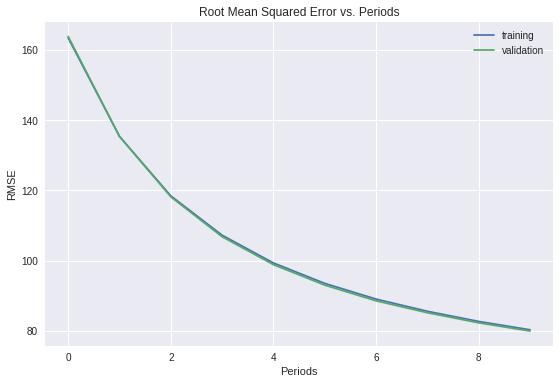

In [14]:
_ = train_model(
    learning_rate=1.0,
    steps=500,
    batch_size=100,
    feature_columns=construct_feature_columns(),
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

 ### Solution

Cliquez ci-dessous pour afficher la solution.

In [0]:
def construct_feature_columns():
  """Construct the TensorFlow Feature Columns.

  Returns:
    A set of feature columns
  """ 
  households = tf.feature_column.numeric_column("households")
  longitude = tf.feature_column.numeric_column("longitude")
  latitude = tf.feature_column.numeric_column("latitude")
  housing_median_age = tf.feature_column.numeric_column("housing_median_age")
  median_income = tf.feature_column.numeric_column("median_income")
  rooms_per_person = tf.feature_column.numeric_column("rooms_per_person")
  
  # Divide households into 7 buckets.
  bucketized_households = tf.feature_column.bucketized_column(
    households, boundaries=get_quantile_based_boundaries(
      training_examples["households"], 7))

  # Divide longitude into 10 buckets.
  bucketized_longitude = tf.feature_column.bucketized_column(
    longitude, boundaries=get_quantile_based_boundaries(
      training_examples["longitude"], 10))
  
  # Divide latitude into 10 buckets.
  bucketized_latitude = tf.feature_column.bucketized_column(
    latitude, boundaries=get_quantile_based_boundaries(
      training_examples["latitude"], 10))

  # Divide housing_median_age into 7 buckets.
  bucketized_housing_median_age = tf.feature_column.bucketized_column(
    housing_median_age, boundaries=get_quantile_based_boundaries(
      training_examples["housing_median_age"], 7))
  
  # Divide median_income into 7 buckets.
  bucketized_median_income = tf.feature_column.bucketized_column(
    median_income, boundaries=get_quantile_based_boundaries(
      training_examples["median_income"], 7))
  
  # Divide rooms_per_person into 7 buckets.
  bucketized_rooms_per_person = tf.feature_column.bucketized_column(
    rooms_per_person, boundaries=get_quantile_based_boundaries(
      training_examples["rooms_per_person"], 7))
  
  # YOUR CODE HERE: Make a feature column for the long_x_lat feature cross
  long_x_lat = tf.feature_column.crossed_column(
  set([bucketized_longitude, bucketized_latitude]), hash_bucket_size=1000) 
  
  feature_columns = set([
    bucketized_longitude,
    bucketized_latitude,
    bucketized_housing_median_age,
    bucketized_households,
    bucketized_median_income,
    bucketized_rooms_per_person,
    long_x_lat])
  
  return feature_columns

In [0]:
_ = train_model(
    learning_rate=1.0,
    steps=500,
    batch_size=100,
    feature_columns=construct_feature_columns(),
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

 ## Exercice facultatif : Essayer d'autres caractéristiques synthétiques

Jusqu'à présent, nous nous en sommes tenus à des croisements de caractéristiques et de colonnes binaires simples. Cependant, il existe bien d'autres combinaisons susceptibles d'améliorer les résultats. Vous pouvez, par exemple, croiser plusieurs colonnes. Que se passe-t-il si vous faites varier le nombre de catégories ? Quelles sont les autres caractéristiques synthétiques auxquelles vous pensez ? Permettent-elles d'améliorer le modèle ?